In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from gerrychain import Graph, Partition, Election, MarkovChain, proposals, updaters, constraints, accept, GeographicPartition
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from functools import partial
from gerrychain.metrics import polsby_popper
import os

In [4]:
PROCESSED_SHAPEFILE_PATH = os.path.join(os.getcwd(), "..", "data", "processed")
NC_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "virginia", "VA_precincts.shp")
EXPORT_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "virginia")
ITERATIONS = 100
SAFE_SEAT_THRESHOLD = 0.66
MINORITY_POP_THRESHOLD = RACE_WINNER_THRESHOLD = 0.5
TOTAL_DISTRICTS = 11

In [3]:
nc_data = gpd.read_file(NC_PATH)
total_votes = nc_data["R_VOTES"] + nc_data["D_VOTES"]
dvshare = nc_data["D_VOTES"] / total_votes
print("Dem Vote Share ", dvshare.mean())
print("Dem Seat Share ", dvshare[dvshare > 0.5].count() / len(nc_data))

rvshare = nc_data["R_VOTES"] / total_votes
print("Rep Vote Share ", rvshare.mean())
print("Rep Seat Share ", rvshare[rvshare > 0.5].count() / len(nc_data))

Dem Vote Share  0.5408576341647199
Dem Seat Share  0.5395653956539566
Rep Vote Share  0.4591423658352801
Rep Seat Share  0.45961459614596145


In [5]:
va_graph = Graph.from_file(NC_PATH, ignore_errors=True)

/Users/sherzodnimatullo/code/projects/416/gerrychain/env/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/sherzodnimatullo/code/projects/416/gerrychain/env/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
/Users/sherzodnimatullo/code/projects/416/gerrychain/env/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(887, 892), (893, 915), (892, 914), (887, 893)}
  warnings.warn(
/Users/sherzodnimatullo/code/projects/416/gerrychain/env/lib/python3.10/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column G17DGOV!
  warnings.warn("NA values found in colu

In [6]:
va_election = Election("CongressionalRace" , {"Democratic": "D_VOTES", "Republican": "R_VOTES"})

<AxesSubplot: >

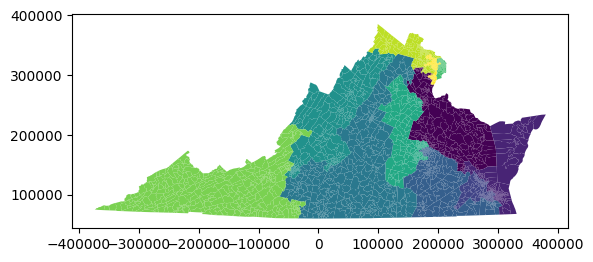

In [7]:
initial_partition = GeographicPartition(
    va_graph,
    assignment="CD_16",
    updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": va_election
    }
)
initial_partition.plot()

In [8]:
ideal_pop = sum(initial_partition["population"].values()) / len(initial_partition)
proposal = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop, epsilon=.02, node_repeats=2)
compactness = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.03)

In [9]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        compactness,
        pop_constraint
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=ITERATIONS
)

In [10]:
opp_rep_graph = {}

thresh = 0.1
thresh_step_size = (1 / ITERATIONS)

print(thresh_step_size)

for partition in chain:
    blk = pd.Series(partition["black"])
    asn = pd.Series(partition["asian"])
    hsp = pd.Series(partition["hisp"])
    tot = pd.Series(partition["population"])
    minority_pop = blk + asn + hsp
    minority_pop_percentage = minority_pop / tot
    
    opp_rep_graph[thresh] = minority_pop_percentage[minority_pop_percentage > thresh].count()
    thresh += thresh_step_size

0.01


In [11]:
opp_rep_graph

{0.1: 10,
 0.11: 10,
 0.12: 10,
 0.13: 10,
 0.14: 10,
 0.15000000000000002: 10,
 0.16000000000000003: 10,
 0.17000000000000004: 10,
 0.18000000000000005: 10,
 0.19000000000000006: 10,
 0.20000000000000007: 9,
 0.21000000000000008: 9,
 0.22000000000000008: 8,
 0.2300000000000001: 8,
 0.2400000000000001: 8,
 0.2500000000000001: 8,
 0.2600000000000001: 8,
 0.27000000000000013: 8,
 0.28000000000000014: 7,
 0.29000000000000015: 7,
 0.30000000000000016: 7,
 0.31000000000000016: 6,
 0.3200000000000002: 6,
 0.3300000000000002: 6,
 0.3400000000000002: 6,
 0.3500000000000002: 6,
 0.3600000000000002: 6,
 0.3700000000000002: 6,
 0.3800000000000002: 5,
 0.39000000000000024: 4,
 0.40000000000000024: 3,
 0.41000000000000025: 3,
 0.42000000000000026: 2,
 0.43000000000000027: 1,
 0.4400000000000003: 2,
 0.4500000000000003: 1,
 0.4600000000000003: 0,
 0.4700000000000003: 0,
 0.4800000000000003: 0,
 0.4900000000000003: 0,
 0.5000000000000003: 0,
 0.5100000000000003: 0,
 0.5200000000000004: 0,
 0.53000000

In [55]:
# Supress user warnings
import warnings
warnings.filterwarnings('ignore')

OPPORTUNITY_REP_COUNT = int(TOTAL_DISTRICTS * 0.25)
print(f"OPPORTUNITY_REP_COUNT: {OPPORTUNITY_REP_COUNT}")
print(f"Running chain for {ITERATIONS} iterations.")

# Calculate polsby popper score, republican and democratic split
polsby_popper_scores = pd.DataFrame()
dem_splits = pd.DataFrame()
rep_splits = pd.DataFrame()
# rep_total_count = pd.DataFrame()
rep_total_count = [0] * (TOTAL_DISTRICTS + 1)
black_pop = pd.DataFrame()
asian_pop = pd.DataFrame()
hisp_pop = pd.DataFrame()
white_pop = pd.DataFrame()
total_pop = pd.DataFrame()
equal_pop = pd.DataFrame()
opportunity_reps_count = pd.DataFrame()

unique_plans = {}


indexes = [1,2,3,4,5,6,7,8,9,10,11]

for partition in chain:
    blk = pd.Series(partition["black"], index=indexes)
    asn = pd.Series(partition["asian"], index=indexes)
    hsp = pd.Series(partition["hisp"], index=indexes)
    wt = pd.Series(partition["white"], index=indexes)
    tot = pd.Series(partition["population"], index=indexes)
    eq_pop = pd.Series(max(partition["population"].values()) - min(partition["population"].values()))
    minority_pop = blk + asn + hsp
    minority_pop_percentage = minority_pop / tot
    opp_reps = pd.Series(minority_pop_percentage[minority_pop_percentage > MINORITY_POP_THRESHOLD].count())
    
    dem = pd.Series(partition["CongressionalRace"].percents("Democratic"), index=indexes)
    rep = pd.Series(partition["CongressionalRace"].percents("Republican"), index=indexes)

    # rep_count = pd.Series(partition["CongressionalRace"].wins("Republican"))
    rep_count = partition["CongressionalRace"].wins("Republican")
    
    polsby_popper_scores = polsby_popper_scores.append(pd.Series(polsby_popper(partition), index=indexes), ignore_index=True)
    black_pop = black_pop.append(blk, ignore_index=True)
    asian_pop = asian_pop.append(asn, ignore_index=True)
    hisp_pop = hisp_pop.append(hsp, ignore_index=True)
    white_pop = white_pop.append(wt, ignore_index=True)
    total_pop = total_pop.append(tot, ignore_index=True)
    opportunity_reps_count = opportunity_reps_count.append(opp_reps, ignore_index=True)
    
    
    equal_pop = equal_pop.append(eq_pop.values[0] / tot, ignore_index=True)
    
    dem_splits = dem_splits.append(dem, ignore_index=True)
    rep_splits = rep_splits.append(rep, ignore_index=True)
    # rep_total_count = rep_total_count.append(rep_count, ignore_index=True)
    rep_total_count[rep_count] += 1
    
    dem_seat_share_percentage = dem[dem > 0.5].count() / TOTAL_DISTRICTS
    dem_vote_share_percentage = dem.mean()

    # For a plan to be unique, it must meet any of the following criteria:
	# 1. > 80% Republican split
	# 2. > 80% Democratic split
	# 3. A district where the minority population is > 40% 
	# 4. Over 50 opporunity representatives within the partition
	# 5. Seat share and vote share are within 5% of each other

    if dem.max() > 0.9:
        unique_plans["High Democrat Concentration In District"] = partition
        
    if rep.max() > 0.9:
        unique_plans["High Republican Concentration In District"] = partition
        
    if minority_pop_percentage[minority_pop_percentage > MINORITY_POP_THRESHOLD].count().sum() >= OPPORTUNITY_REP_COUNT:
        unique_plans["High Opportunity Representative Count"] = partition
        
    if abs(dem_seat_share_percentage - dem_vote_share_percentage) > 0.15:
        unique_plans["Large Difference Between Democrat Vote Share and Seat Share"] = partition
        
    if abs((1-dem_seat_share_percentage) - (1-dem_vote_share_percentage)) > 0.15:
        unique_plans["Large Difference Between Republican Vote Share and Seat Share"] = partition
        
        
display(f"Number of unique plans: {len(unique_plans)}")

rep_safe_districts = rep_splits[rep_splits > SAFE_SEAT_THRESHOLD].count(axis=1)
dem_safe_districts = dem_splits[dem_splits > SAFE_SEAT_THRESHOLD].count(axis=1)
minority_pop = black_pop + asian_pop + hisp_pop

dem_seat_share = dem_splits[dem_splits > RACE_WINNER_THRESHOLD].count(axis=1)
dem_seat_share_percentage = dem_seat_share / TOTAL_DISTRICTS

rep_seat_share = rep_splits[rep_splits > RACE_WINNER_THRESHOLD].count(axis=1)
rep_seat_share_percentage = rep_seat_share / TOTAL_DISTRICTS
    

OPPORTUNITY_REP_COUNT: 2
Running chain for 100 iterations.


'Number of unique plans: 2'

In [56]:
rep_total_count = {i: rep_total_count[i] for i in range(0, len(rep_total_count))}
rep_total_count

{0: 0, 1: 0, 2: 8, 3: 69, 4: 23, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}

In [57]:
dis1 = pd.Series()
dis2 = pd.Series()
dis3 = pd.Series()
dis4 = pd.Series()
dis5 = pd.Series()
dis6 = pd.Series()
dis7 = pd.Series()
dis8 = pd.Series()
dis9 = pd.Series()
dis10 = pd.Series()
dis11 = pd.Series()
opportunity_reps  = pd.DataFrame()
for plan in chain:
    for district, pop in plan["population"].items():
        district = int(district)
        minority_pop_dist = plan["black"][district] + plan["asian"][district] + plan["hisp"][district]
        if minority_pop_dist > MINORITY_POP_THRESHOLD * pop:
            if district == 1:
                dis1 = dis1.append(pd.Series(1), ignore_index=True)
            elif district == 2:
                dis2 = dis2.append(pd.Series(1), ignore_index=True)
            elif district == 3:
                dis3 = dis3.append(pd.Series(1), ignore_index=True)
            elif district == 4:
                dis4 = dis4.append(pd.Series(1), ignore_index=True)
            elif district == 5:
                dis5 = dis5.append(pd.Series(1), ignore_index=True)
            elif district == 6:
                dis6 = dis6.append(pd.Series(1), ignore_index=True)
            elif district == 7:
                dis7 = dis7.append(pd.Series(1), ignore_index=True)
            elif district == 8:
                dis8 = dis8.append(pd.Series(1), ignore_index=True)
            elif district == 9:
                dis9 = dis9.append(pd.Series(1), ignore_index=True)
            elif district == 10:
                dis10 = dis10.append(pd.Series(1), ignore_index=True)
            elif district == 11:
                dis11 = dis11.append(pd.Series(1), ignore_index=True)
        else:
            if district == 1:
                dis1 = dis1.append(pd.Series(0), ignore_index=True)
            elif district == 2:
                dis2 = dis2.append(pd.Series(0), ignore_index=True)
            elif district == 3:
                dis3 = dis3.append(pd.Series(0), ignore_index=True)
            elif district == 4:
                dis4 = dis4.append(pd.Series(0), ignore_index=True)
            elif district == 5:
                dis5 = dis5.append(pd.Series(0), ignore_index=True)
            elif district == 6:
                dis6 = dis6.append(pd.Series(0), ignore_index=True)
            elif district == 7:
                dis7 = dis7.append(pd.Series(0), ignore_index=True)
            elif district == 8:
                dis8 = dis8.append(pd.Series(0), ignore_index=True)
            elif district == 9:
                dis9 = dis9.append(pd.Series(0), ignore_index=True)
            elif district == 10:
                dis10 = dis10.append(pd.Series(0), ignore_index=True)
            elif district == 11:
                dis11 = dis11.append(pd.Series(0), ignore_index=True)


# add the series to the dataframe
opportunity_reps[0] = dis1
opportunity_reps[1] = dis2
opportunity_reps[2] = dis3
opportunity_reps[3] = dis4
opportunity_reps[4] = dis5
opportunity_reps[5] = dis6
opportunity_reps[6] = dis7
opportunity_reps[7] = dis8
opportunity_reps[8] = dis9
opportunity_reps[9] = dis10
opportunity_reps[10] = dis11

In [58]:
opportunity_reps.sum(axis=0)

0     0
1     9
2     2
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

# Polsby Popper Scores

In [59]:
polsby_popper_scores

,1,2,3,4,5,6,7,8,9,10,11
0,0.226974,0.217129,0.216333,0.208303,0.153135,0.163106,0.195400,0.251961,0.181249,0.122377,0.091901
1,0.226974,0.217129,0.216333,0.208303,0.139302,0.163106,0.195400,0.251961,0.158841,0.122377,0.091901
2,0.226974,0.217129,0.216333,0.208303,0.139302,0.147506,0.195400,0.251961,0.146590,0.122377,0.091901
3,0.226974,0.217129,0.216333,0.208303,0.136738,0.147506,0.195400,0.251961,0.146590,0.130388,0.091901
4,0.226974,0.210385,0.352096,0.208303,0.136738,0.147506,0.195400,0.251961,0.146590,0.130388,0.091901
...,...,...,...,...,...,...,...,...,...,...,...
95,0.127536,0.203144,0.171452,0.159029,0.183633,0.137806,0.111577,0.115369,0.161881,0.184004,0.178815
96,0.137556,0.203144,0.171452,0.159029,0.183633,0.137806,0.111577,0.115369,0.155363,0.184004,0.178815
97,0.137556,0.203144,0.171452,0.159029,0.217374,0.137806,0.127084,0.115369,0.155363,0.184004,0.178815
98,0.137556,0.203144,0.171452,0.159029,0.217374,0.137806,0.127084,0.198363,0.155363,0.184004,0.114022


# Republican Party Splits

In [60]:
rep_splits.mean()

1     0.437079
2     0.403114
3     0.404852
4     0.495954
5     0.538977
6     0.473850
7     0.435419
8     0.257261
9     0.600114
10    0.371232
11    0.259589
dtype: float64

# Republican Safe Districts

In [61]:
rep_splits[rep_splits > SAFE_SEAT_THRESHOLD].count()

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
dtype: int64

# Democrat Party Splits

In [62]:
dem_splits.mean()

1     0.562921
2     0.596886
3     0.595148
4     0.504046
5     0.461023
6     0.526150
7     0.564581
8     0.742739
9     0.399886
10    0.628768
11    0.740411
dtype: float64

# Democrat Safe Districts

In [63]:
dem_splits[dem_splits > SAFE_SEAT_THRESHOLD].count()

1     14
2     18
3     20
4      3
5      4
6     14
7     11
8     78
9      4
10    26
11    93
dtype: int64

# Vote Share Seat Share
## Democrat

In [64]:
dem_vote_share_percentage

0.5750472882679795

# Box & Whisker for Population

In [65]:
black_pop_box_data = pd.DataFrame(black_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
asian_pop_box_data = pd.DataFrame(asian_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
hispanic_pop_box_data = pd.DataFrame(hisp_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
white_pop_box_data = pd.DataFrame(white_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
total_pop_box_data = pd.DataFrame(total_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])

dem_split_box_data = pd.DataFrame(dem_splits.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
rep_split_box_data = pd.DataFrame(rep_splits.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])

In [66]:
dem_split_box_data

,1,2,3,4,5,6,7,8,9,10,11
min,0.492960,0.511638,0.514413,0.354741,0.358466,0.353137,0.418251,0.495661,0.348318,0.491704,0.562024
25%,0.516125,0.569891,0.553747,0.474334,0.373449,0.412177,0.489730,0.766300,0.353902,0.605479,0.732082
50%,0.557795,0.586091,0.575771,0.488167,0.421240,0.500269,0.607379,0.795734,0.403465,0.605561,0.736904
mean,0.562921,0.596886,0.595148,0.504046,0.461023,0.526150,0.564581,0.742739,0.399886,0.628768,0.740411
75%,0.620587,0.618665,0.620213,0.554679,0.517740,0.654902,0.623037,0.802713,0.413685,0.711083,0.753783
max,0.674176,0.683403,0.711683,0.752027,0.671308,0.671973,0.660467,0.802713,0.672014,0.760491,0.796356


# Export Time

## Unique Plan District

In [67]:
for reason in unique_plans:
    plan = unique_plans[reason]
    r_split = pd.DataFrame(pd.Series(plan["CongressionalRace"].percents("Republican"), index=indexes))
    r_split.columns = ["R_votes"]


    gdf = gpd.GeoDataFrame({"assignment": plan.assignment.to_series()}, geometry=plan.graph.geometry)
    district_shapes = gdf.dissolve(by='assignment', aggfunc='sum') # Combine the precincts to form districts
    district_shapes = district_shapes.to_crs(epsg="4326")
    district_shapes = district_shapes.join(r_split)
    district_shapes["R_votes"] = district_shapes["R_votes"].apply(lambda x: "R" if x > 0.5 else "D")
    district_shapes = district_shapes.rename(columns={"R_votes": "party"})
#     district_shapes.to_file(f"{EXPORT_PATH}/unique plans/{reason}.geojson", driver='GeoJSON')

## Unique Plan Data

In [68]:
import json

unique_plan_data = {}

for reason in unique_plans:
    plan = unique_plans[reason]
    blk = pd.Series(plan["black"], index=indexes)
    asn = pd.Series(plan["asian"], index=indexes)
    hsp = pd.Series(plan["hisp"], index=indexes)
    wt = pd.Series(plan["white"], index=indexes)
    tot = pd.Series(plan["population"], index=indexes)
    minority_population = blk + asn + hsp
    minority_pop_percentage = minority_population / tot
    
    dem = pd.Series(plan["CongressionalRace"].percents("Democratic"), index=indexes)
    rep = pd.Series(plan["CongressionalRace"].percents("Republican"), index=indexes)
    
    safe_districts = dem[dem > SAFE_SEAT_THRESHOLD].count() + rep[rep > SAFE_SEAT_THRESHOLD].count()
    unique_plan_opportunity_reps = minority_pop_percentage[minority_pop_percentage > MINORITY_POP_THRESHOLD].count()
    pp_scores = pd.Series(polsby_popper(partition), index=indexes)
    

    
    unique_plan_data[reason] = {
        "blk_pop": blk.to_dict(),
        "asn_pop": asn.to_dict(),
        "hsp_pop": hsp.to_dict(),
        "wt_pop": wt.to_dict(),
        "tot_pop": tot.to_dict(),
        "minority_pop": minority_population.to_dict(),
        "dem_split": dem.to_dict(),
        "rep_split": rep.to_dict(),
        "safe_districts": int(safe_districts),
        "opportunity_reps": int(unique_plan_opportunity_reps),
        "polsby_popper_scores": pp_scores.to_dict()
    }

In [69]:
# # Export everything I've done so far to a JSON file

import json
data = {}

data["thresholds"] = {
    "SAFE_SEAT_THRESHOLD": SAFE_SEAT_THRESHOLD,
    "MINORITY_POP_THRESHOLD": MINORITY_POP_THRESHOLD, 
    "RACE_WINNER_THRESHOLD": RACE_WINNER_THRESHOLD,
    "OPPORTUNITY_REP_COUNT": OPPORTUNITY_REP_COUNT
}
data["polsby_popper_scores"] = polsby_popper_scores.mean().to_dict()
data["rep_splits"] = rep_splits.mean().to_dict()
data["dem_splits"] = dem_splits.mean().to_dict()
data["black_pop"] = black_pop.mean().to_dict()
data["asian_pop"] = asian_pop.mean().to_dict()
data["hispanic_pop"] = hisp_pop.mean().to_dict()
data["white_pop"] = white_pop.mean().to_dict()
data["total_pop"] = total_pop.mean().to_dict()
data["minority_pop"] = minority_pop.mean().to_dict()
data["opportunity_reps"] = float(opportunity_reps_count.mean())
data["equal_pop"] = equal_pop.mean().mean()
data["dem_seat_share_percentage"] = dem_seat_share_percentage.mean()
data["dem_vote_share_percentage"] = dem_splits.mean().mean()
data["dem_split_box_data"] = dem_split_box_data.to_dict()
data["rep_seat_share_percentage"] = rep_seat_share_percentage.mean()
data["rep_vote_share_percentage"] = rep_splits.mean().mean()
data["rep_split_box_data"] = rep_split_box_data.to_dict()
data["black_pop_box_data"] = black_pop_box_data.to_dict()
data["asian_pop_box_data"] = asian_pop_box_data.to_dict()
data["hispanic_pop_box_data"] = hispanic_pop_box_data.to_dict()
data["white_pop_box_data"] = white_pop_box_data.to_dict()
data["total_pop_box_data"] = total_pop_box_data.to_dict()
data["unique_plans_data"] = unique_plan_data
data["bar_data"] = {
    "opportunity_reps": opportunity_reps.sum(axis=0).to_dict(),
    "rep_total_count": rep_total_count
}

with open(f'{EXPORT_PATH}/data.json', 'w') as outfile:
    json.dump(data, outfile)